In [1]:
import numpy as np
from commpy.utilities  import upsample
from optic.models.devices import RingModulator, photodiode
from optic.comm.modulation import modulateGray
from optic.dsp.core import pulseShape, signal_power

try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt

Ring Resonator initialized with round-trip time: 5.030e-13 seconds
RC filter enabled with time constant: 4.000e-12 seconds


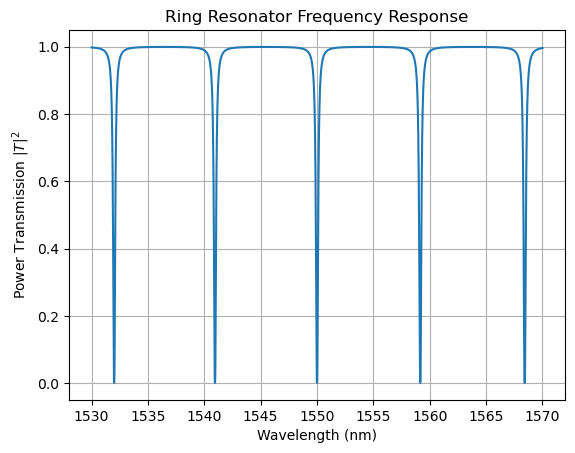

Free Spectral Range: 9.104 nm


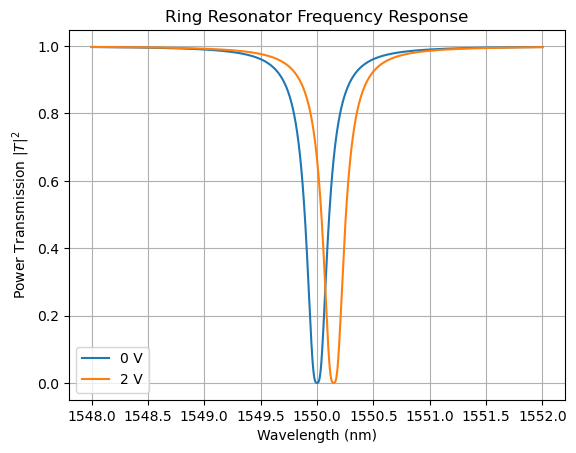

Full width at half maximum 0.143 nm
Loaded quality factor 10838.024511619844
Finesse: 63.7
Photon lifetime: 8.918 ps


In [2]:
# Create a ring resonator
ring = RingModulator(
    radius=10e-6,
    a=4000,
    kappa=0.20,
    rc_filter_enabled=True,  # Enable RC filter for voltage modulation
    rc_time_constant=4e-12  # Set time constant for RC filter (6 ps)
)

# Plot frequency response to validate FSR
wavelengths, power_transmission = ring.plot_frequency_response(lambda_start=1530e-9,lambda_end=1570e-9,points=int(1e5))
plt.figure()
plt.plot(wavelengths * 1e9, power_transmission)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power Transmission ' + r'$|T|^{2}$')
plt.title('Ring Resonator Frequency Response')
plt.grid()
plt.show()

# Calculate and display parameters
print(f"Free Spectral Range: {ring.FSR*1e9:.3f} nm")


plt.figure()
wavelengths, power_transmission = ring.plot_frequency_response(lambda_start=1548e-9,lambda_end=1552e-9,points=int(1e5),voltage=0)
plt.plot(wavelengths * 1e9, power_transmission)
wavelengths, power_transmission = ring.plot_frequency_response(lambda_start=1548e-9,lambda_end=1552e-9,points=int(1e5),voltage=2)
plt.plot(wavelengths * 1e9, power_transmission)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power Transmission ' + r'$|T|^{2}$')
plt.legend(['0 V', '2 V'])
plt.title('Ring Resonator Frequency Response')
plt.grid()
plt.show()

print(f"Full width at half maximum {ring.FWHM*1e9:.3} nm")
print(f"Loaded quality factor {ring.quality_factor}")
print(f"Finesse: {ring.finesse:.1f}")
print(f"Photon lifetime: {ring.photon_lifetime*1e12:.3f} ps")

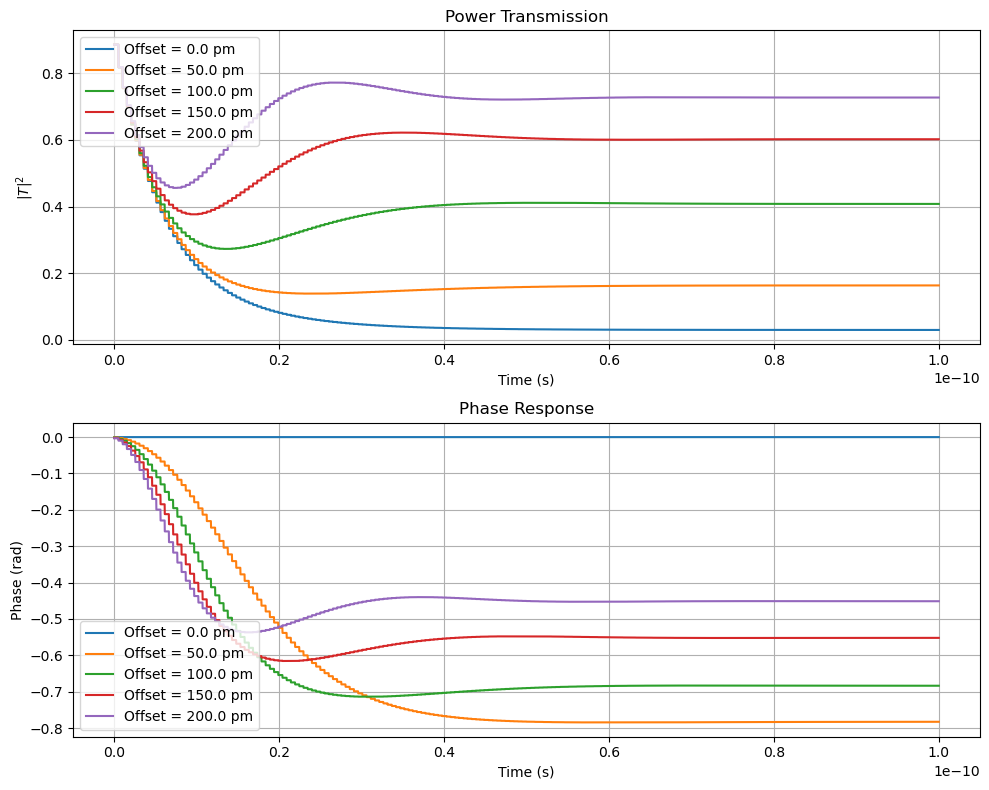

In [3]:
# Time domain simulation
t_max = 1e-10
dt = 1e-14
t = np.linspace(0, t_max, int(t_max/dt) + 1)

# Create input field (constant amplitude)
input_field = np.ones(len(t), dtype=complex)

# Define wavelength offsets to simulate
wavelength_offsets = [0, 50e-12, 100e-12, 150e-12, 200e-12]

plt.figure(figsize=(10, 8))

for i, wavelength_offset in enumerate(wavelength_offsets):
    output_field = ring.process_waveform(input_field, dt, wavelength_offset=wavelength_offset, voltage_waveform=None)
    
    # Plot power transmission
    plt.subplot(2, 1, 1)
    plt.plot(t, np.abs(output_field)**2, label=f'Offset = {wavelength_offset*1e12:.1f} pm')
    
    # Plot phase response
    plt.subplot(2, 1, 2)
    plt.plot(t, np.angle(output_field), label=f'Offset = {wavelength_offset*1e12:.1f} pm')

# Format plots
plt.subplot(2, 1, 1)
plt.xlabel('Time (s)')
plt.ylabel(r'$|T|^{2}$')
plt.title('Power Transmission')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.title('Phase Response')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Test OOK Ring Resonator Response

Average power of the modulated optical signal [mW]: 0.439 mW
Average power of the modulated optical signal [dBm]: -3.579 dBm


c:\anaconda\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\anaconda\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


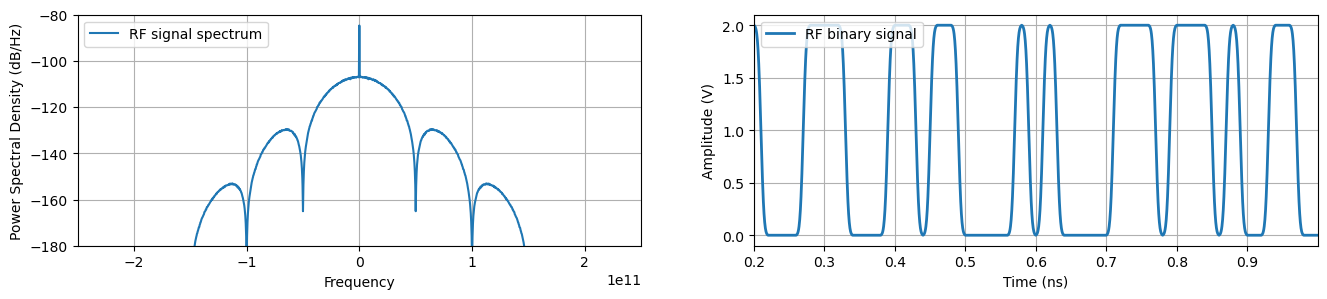

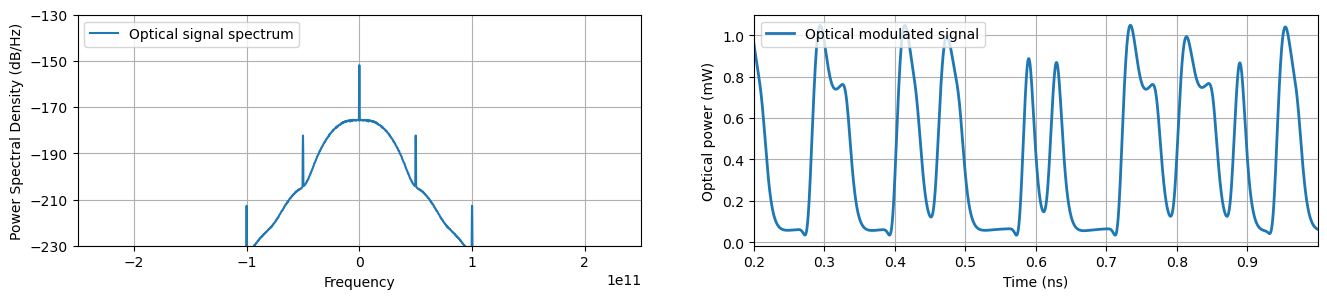

In [4]:
# simulation parameters
SpS = 64     # samples per symbol
M = 2        # order of the modulation format
Rs = 50e9    # Symbol rate (for OOK case Rs = Rb)
Fs = Rs*SpS  # Sampling frequency
Ts = 1/Fs    # Sampling period

# Laser power
Pi_dBm = 0         # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm) # convert from dBm to W

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(4e5))

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    

#Scale voltage up
symbTx = symbTx/np.max(symbTx) + 1 # scale to [0, 2] for MZM

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)
output_field = ring.process_waveform([Ai]*len(sigTx), Ts, wavelength_offset=25e-12, voltage_waveform=sigTx)

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signal_power(output_field)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signal_power(output_field)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*40,16*200)
t = interval*Ts/1e-9

# plot psd
axs[0].set_xlim(-5*Rs,5*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (V)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-5*Rs,5*Rs);
axs[0].set_ylim(-230,-130);
axs[0].psd(np.abs(output_field)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(output_field[interval])**2/Pi, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Optical power (mW)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

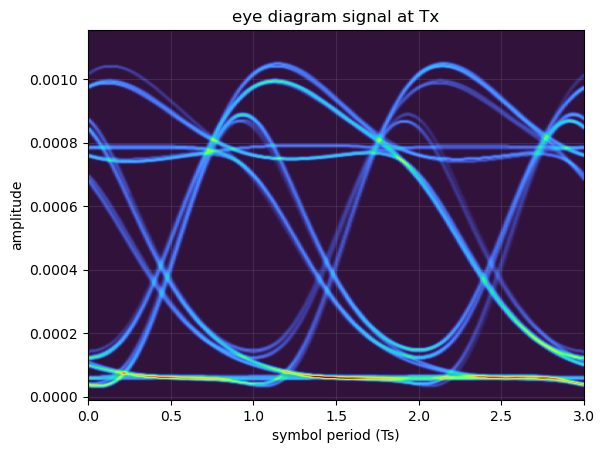

In [5]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs

I_Tx = photodiode(output_field, paramPD) # transmitted signal
discard = 100
eyediagram(I_Tx[discard:-discard], I_Tx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')